In [1]:
Threads.nthreads()

16

In [2]:
using Plots
using DSP
using FFTW

In [3]:
include("radarsim.jl")
using .radarsim;

In [4]:
samp_rate = 5e6  #hz
prf = 100 #Hz
duty_factor = .15; #.05
β = 1e6; #Pulse Bandwidth
repetitions = 128;
fc = 900_000_000; #Hz

Gt = 40; #dB
Gr = 45; #dB
system_loss = 6; #dB

targets = [Target(560_094, 0), Target(800_000, 0)]
num_targets = length(targets);

In [5]:
τ = duty_factor * (1/prf);
λ = (1/fc) * c;

In [6]:
(1/prf * c / 2) / 1000 #Maximum Range KM

1498.96229

In [7]:
(τ * c / 2) / 1000 #Minimum Range KM

224.8443435

In [8]:
t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="HalfSin");

In [14]:
prt = 1/prf;
t = 1/samp_rate:1/samp_rate:prt;
a = sin.(1/(prt/pi).*t);

In [15]:
plot(a)

In [ ]:
a = ones(length(t));
if(length(a) > τ * samp_rate)
    a[round(Int, τ*samp_rate):end] .= 0
end

In [ ]:

plot(a)

In [9]:
rx_pulse_train = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=-12);

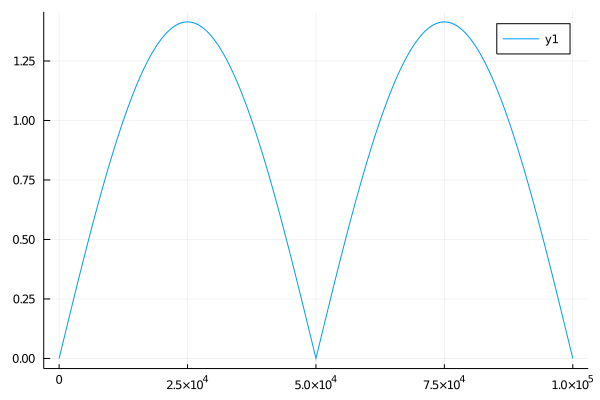

In [11]:
plot(abs.(pulse_train[1:Int(1e5)]))

In [ ]:
fft_size = 128;
spec = spectrogram(pulse_train[begin:round(Int, τ*samp_rate)], fft_size; fs=samp_rate); #+ pulse_train

heatmap(spec.time, LinRange(0,samp_rate/2, round(Int, fft_size/2)), spec.power[begin:round(Int, fft_size/2) , :], xguide="Time (Seconds)", yguide="Frequency (hz)", title="Pulse Spectrogram")

In [ ]:
null, p = single_pulse(samp_rate, prf, τ, β);
pulse_compression = conv(rx_pulse_train, reverse(p[begin:round(Int, τ*samp_rate)]));

In [ ]:
pulse_compression = pulse_compression[1:length(rx_pulse_train)];


In [ ]:
len = Int(1/prf * samp_rate);
range_stacked = reshape(pulse_compression, len, repetitions);


In [ ]:
#heatmap(abs.(range_stacked))

In [ ]:
range_doppler = fft((range_stacked), (2,));


In [ ]:
range_doppler

In [ ]:

# for i in 1:length(range_doppler[1,:])
#     range_doppler[i,:] = fftshift(range_doppler[i,:]);
# end

In [ ]:
range_doppler

In [ ]:
maxRange = ((1/prf * c)/2)
maxDop = (prf*λ)/4;

rangeLabel = LinRange(0, maxRange , 13);
dopplerLabel = LinRange(-maxDop,maxDop,13);

rangeLabel = round.(Int, (rangeLabel ./ 1000));
dopplerLabel = round.(dopplerLabel, digits=2);

In [ ]:
heatmap(20*log10.(abs.(range_doppler)), xlabel="Doppler (m/s)", ylabel="Range (km)", xticks=(LinRange(0,repetitions, 13), dopplerLabel), yticks=(LinRange(1,len,13), rangeLabel))

In [ ]:
v = 0:(maxDop * 4);

r = ((c^2)/(8*fc)) ./ v;

In [ ]:
plot(v,r./1000, labels="Range Ambiguouity Function", xlabel="Maximum unambiguous Velocity (m/s)", ylabel="Maximum unambiguous Range (km)")